<a href="https://colab.research.google.com/github/PadariyaDebo/Synthetic-Data-Genration-using-GAN/blob/main/DP_vs_Non_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendp-smartnoise diffprivlib pandas==0.25.3 pytest pyyaml pandasql mlflow connexion ctgan==0.2.2 opacus==0.11.0 torch==1.6.0 seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193 kB 37.8 MB/s 
     |████████████████████████████████| 167 kB 68.1 MB/s 
     |████████████████████████████████| 10.4 MB 56.3 MB/s 
     |████████████████████████████████| 17.9 MB 621 kB/s 
     |████████████████████████████████| 95 kB 3.3 MB/s 
     |████████████████████████████████| 90 kB 10.7 MB/s 
     |████████████████████████████████| 748.8 MB 18 kB/s 
     |████████████████████████████████| 6.8 MB 51.2 MB/s 
     |████████████████████████████████| 877 kB 66.1 MB/s 
     |████████████████████████████████| 47 kB 4.5 MB/s 
     |████████████████████████████████| 12.4 MB 32.0 MB/s 
     |████████████████████████████████| 77 kB 6.9 MB/s 
     |████████████████████████████████| 19.1 MB 1.1 MB/s 
     |████████████████████████████████| 21.0 MB 1.3 MB/s 
     |████████████████████████████████| 23.2 MB 1.4 MB/s 
     |██████████████████████████████

In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [3]:
n_samples = 100000
n_features = 7
n_informative = 7 # relevant features to explain target
n_redundant = 0 # linear combinations of informative
n_repeated = 0 # random copies of informative and redundant
n_useless = n_features - n_informative - n_redundant - n_repeated # noise

n_classes = 10
seed = 1

In [4]:
# define feature names
def feature_names (n_items, prefix = 'feature'):
    names = []
    for i in range(n_items):
        names.append(prefix + '_' + str(i))
    return names

inf_features = feature_names(n_informative, 'inf')
red_features = feature_names(n_redundant, 'red')
rep_features = feature_names(n_repeated, 'rep')
useless_features = feature_names(n_useless, 'noise')

feature_names = inf_features + red_features + rep_features + useless_features

X, y = make_classification(n_samples=n_samples, 
                    n_features=n_features, 
                    n_informative=n_informative, 
                    n_redundant=n_redundant, 
                    n_repeated=n_repeated, 
                    n_classes=n_classes, 
                    n_clusters_per_class=2, 
                    weights=None, 
                    flip_y=0.03, 
                    class_sep=5.0, 
                    hypercube=True, 
                    shift=15.0,
                    scale=0.5,
                    shuffle=False, 
                    random_state=seed)

In [5]:
# Convert to Dataframe
Z=np.zeros((X.shape[0], X.shape[1]+1))
Z[:,:-1]=X
Z[:,-1]=y

columns = feature_names + ['class']
df = pd.DataFrame(Z, columns=columns)
df['class'] = df['class'].astype('int32')

df.head()

inf_0      inf_1      inf_2      inf_3     inf_4     inf_5      inf_6  \
0   9.622483  10.776050   9.671523   9.976871  4.844616  4.195274   9.181214   
1   8.758071  12.884599  10.786024  10.314471  5.946004  5.579375   9.461131   
2  10.950740   9.837627  10.308713   9.139833  5.224695  5.835789  10.724998   
3  10.208986   9.960696   9.952239  10.574564  5.025228  4.649186  10.239452   
4   8.706916   9.653345   9.507716  10.181471  4.246708  4.525342   8.781617   

   class  
0      0  
1      0  
2      0  
3      0  
4      0

<Figure size 432x288 with 0 Axes>

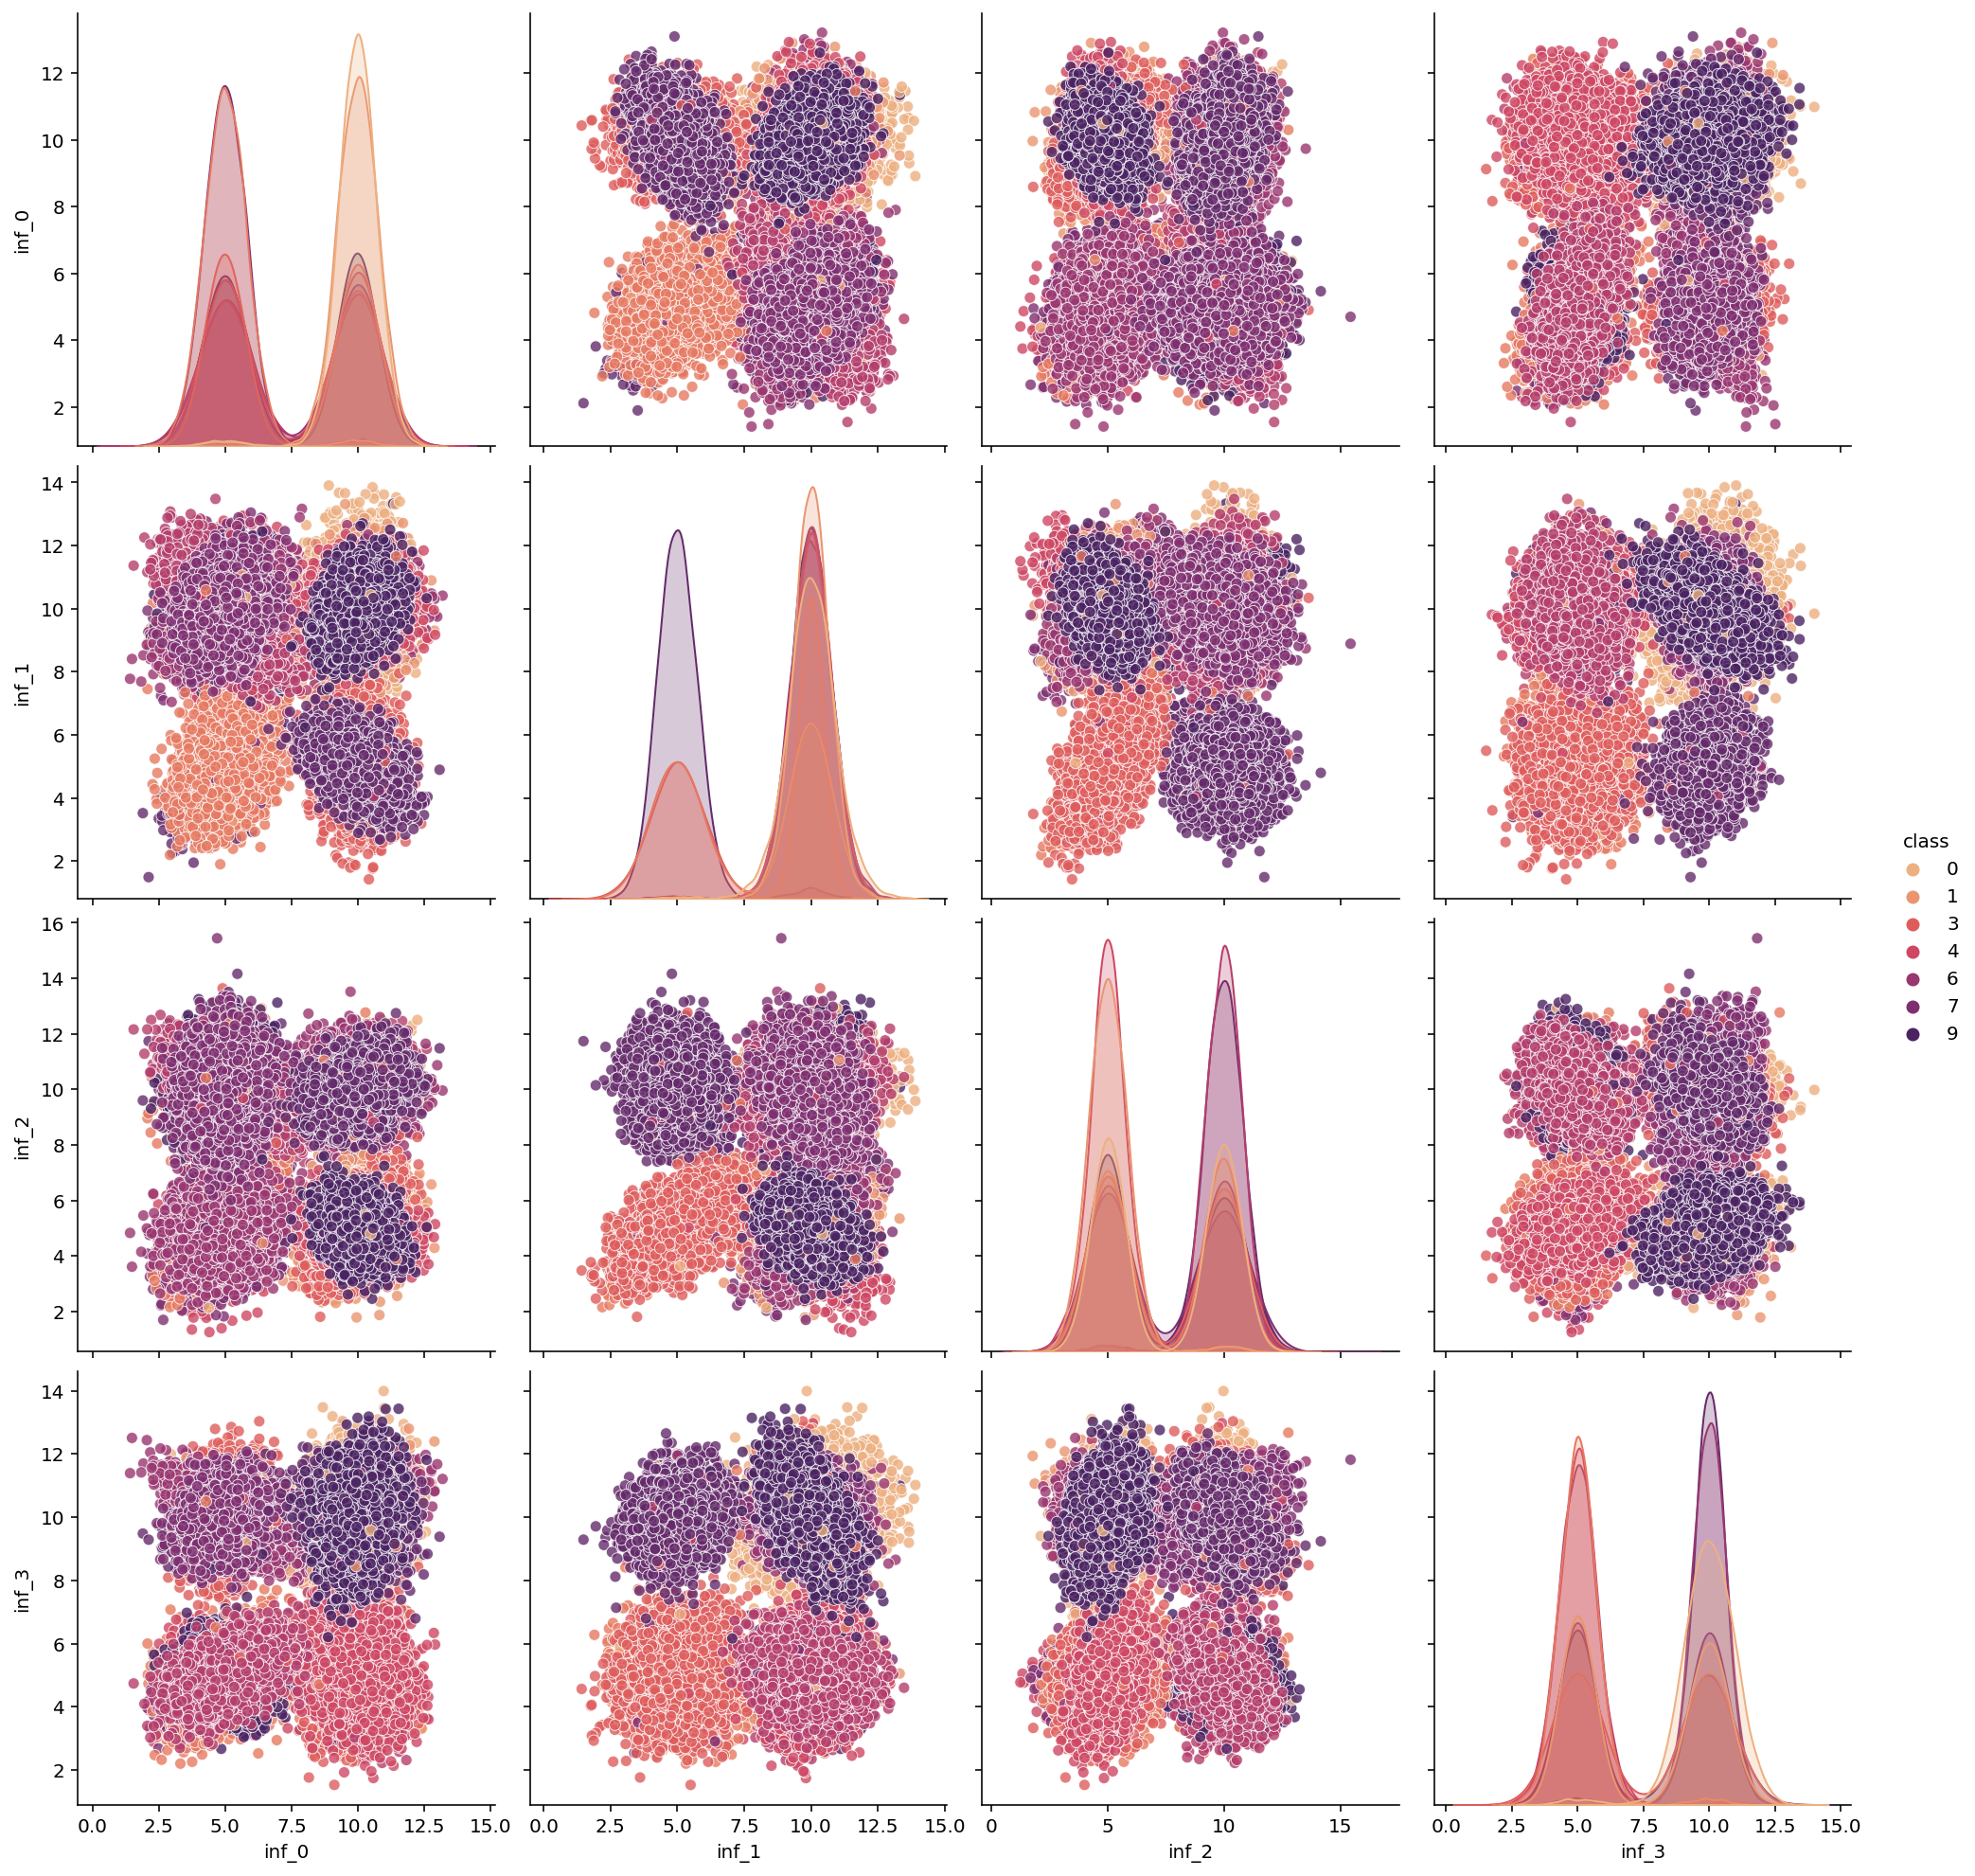

In [6]:
plot_features = inf_features[:4]

plt.clf()
g = sns.pairplot(df, vars=plot_features, height=3.5, hue='class', plot_kws=dict(alpha=0.8), palette='flare')
plt.show()

In [7]:
Xy_train, Xy_test = train_test_split(df, test_size=0.2, stratify = df['class'], random_state = seed)

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

Xy_train.loc[:,inf_features] = scaler.fit_transform(Xy_train.loc[:,inf_features])
Xy_test.loc[:,inf_features] = scaler.transform(Xy_test.loc[:,inf_features])

In [9]:
X_train = Xy_train.drop('class', axis=1)
y_train = Xy_train['class']

X_test = Xy_test.drop('class', axis=1)
y_test = Xy_test['class']

In [11]:
np.random.seed(seed)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state=seed)
clf.fit(X_train, y_train)    

def evaluate (clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred))
    y_probs = clf.predict_proba(X_test)
    roc_score = roc_auc_score(y_test, y_probs, multi_class='ovo')
    print('ROC AUC Score: %f' %roc_score)
    
evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      2006
           1       0.97      0.98      0.97      1998
           2       0.97      0.96      0.97      2001
           3       0.97      0.97      0.97      1993
           4       0.98      0.97      0.97      2000
           5       0.97      0.98      0.97      2003
           6       0.97      0.98      0.97      1988
           7       0.97      0.97      0.97      2006
           8       0.97      0.97      0.97      2006
           9       0.97      0.97      0.97      1999

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

ROC AUC Score: 0.984251


In [12]:
from diffprivlib.models import LogisticRegression as DPLR

clf = DPLR(epsilon=3.0, data_norm=5.026)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2006
           1       0.84      0.88      0.86      1998
           2       0.96      0.95      0.95      2001
           3       0.78      0.79      0.78      1993
           4       0.88      0.84      0.86      2000
           5       0.89      0.94      0.91      2003
           6       0.80      0.86      0.83      1988
           7       0.84      0.95      0.89      2006
           8       0.97      0.97      0.97      2006
           9       0.81      0.62      0.70      1999

    accuracy                           0.87     20000
   macro avg       0.87      0.87      0.87     20000
weighted avg       0.87      0.87      0.87     20000

ROC AUC Score: 0.976757


In [13]:
from diffprivlib.models import GaussianNB as DPNB

# Required parameters for DP version of Gaussian Naive Bayes
lower = list(X_train.min())
upper = list(X_train.max())
bounds = (lower, upper)

clf = DPNB(epsilon=3.0, bounds=bounds)
clf.fit(X_train, y_train)

evaluate(clf, X_test, y_test)

              precision    recall  f1-score   support

           0       0.66      0.94      0.77      2006
           1       0.37      0.25      0.30      1998
           2       0.97      0.96      0.97      2001
           3       0.91      0.97      0.94      1993
           4       0.67      0.65      0.66      2000
           5       0.97      0.96      0.96      2003
           6       0.69      0.95      0.80      1988
           7       0.64      0.93      0.76      2006
           8       0.97      0.97      0.97      2006
           9       0.39      0.03      0.05      1999

    accuracy                           0.76     20000
   macro avg       0.72      0.76      0.72     20000
weighted avg       0.72      0.76      0.72     20000

ROC AUC Score: 0.962421


In [14]:
Xy_train.head()

inf_0     inf_1     inf_2     inf_3     inf_4     inf_5     inf_6  \
19593 -1.062811  0.289829  1.485568  0.177296 -1.045975 -1.258811 -0.449118   
57406  1.155943  0.672817 -0.521652 -0.984263  1.127483  0.963554  1.319874   
88599 -1.320792  0.184815  0.968994  0.681540 -0.964468  0.686489  1.161721   
51135  0.687193  0.146141 -0.751915  1.014100  1.075303 -1.077278 -0.459374   
96113  0.618073  0.484003 -1.094734  0.767910 -1.055770  0.879046 -0.846655   

       class  
19593      3  
57406      1  
88599      7  
51135      0  
96113      9